In [1]:
import torch
import torch.nn.functional as F
from mobilenetv3_1d import mobilenetv3
from dataset import RML22_Dataset
from torchvision.transforms import Lambda
import yaml
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

/home/ogech/moco_mod_class/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [3]:
test_ds = RML22_Dataset(
    "RML22_test.h5", data_txfm=Lambda(lambda x: torch.tensor(x)))
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=512, shuffle=False)

In [5]:
# load the class map from config
# experiment_name = "07dec_supervised"
# experiment_name = "09dec_ssl_0.3_lnc"
experiment_name = "09dec_random_weights"

with open(f"experiments/{experiment_name}/config.yaml") as f:
    config = yaml.safe_load(f)

In [6]:
# plot accuracy against snr levels
model = mobilenetv3(in_chans=2, num_classes=config.get("nclasses"),
                    drop_rate=0.2, drop_path_rate=0.7).to(device)

weights = torch.load(
    f"experiments/{experiment_name}/weights.pth", weights_only=True)
model.load_state_dict(weights)

<All keys matched successfully>

In [7]:
model.eval()

true_labels = []
pred_labels = []

with torch.no_grad():
    for xb, yb in test_dl:
        xb, yb = xb.to(device), yb.to(device)
        yb_hat = model(xb)
        _, predicted = torch.max(F.softmax(yb_hat, dim=-1), 1)
        # stores a tuple of (modulation, snr)
        true_labels.extend(yb.cpu().numpy())
        # stores the predicted modulation
        pred_labels.extend(predicted.cpu().numpy())

# plot the accuracy against snr levels and modulation types
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

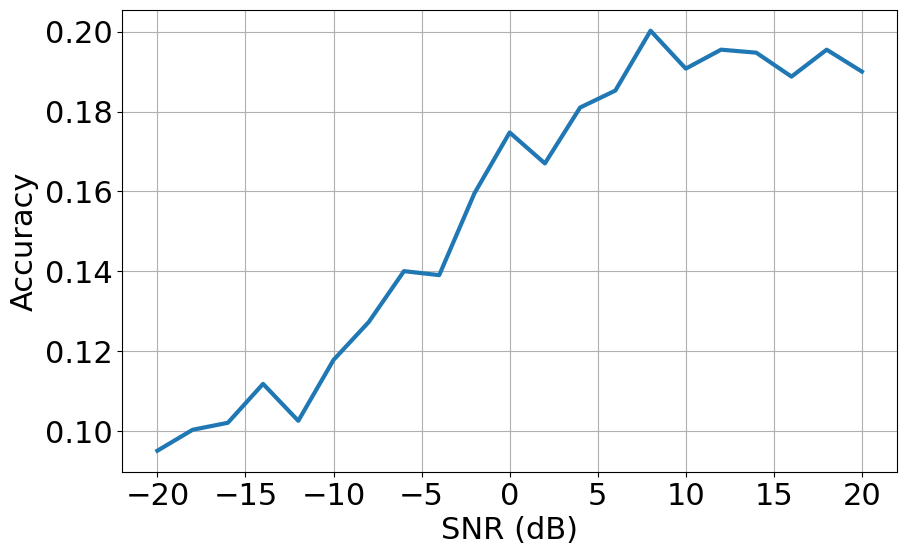

In [8]:
acc_snr = []
for snr in np.unique(true_labels[:, 1]):
    idx = true_labels[:, 1] == snr
    acc = accuracy_score(true_labels[idx, 0], pred_labels[idx])
    # print(f"SNR: {snr}dB, Accuracy: {acc}")
    acc_snr.append((snr, acc))

acc_snr = np.array(acc_snr)

plt.figure(figsize=(10, 6))
sns.lineplot(x=acc_snr[:, 0], y=acc_snr[:, 1], linewidth=3)
plt.xlabel("SNR (dB)", fontsize=22)
plt.ylabel("Accuracy", fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.grid()

# save to experiments folder
plt.savefig(

    f"experiments/{experiment_name}/accuracy_vs_snr.png", dpi=300, bbox_inches='tight')

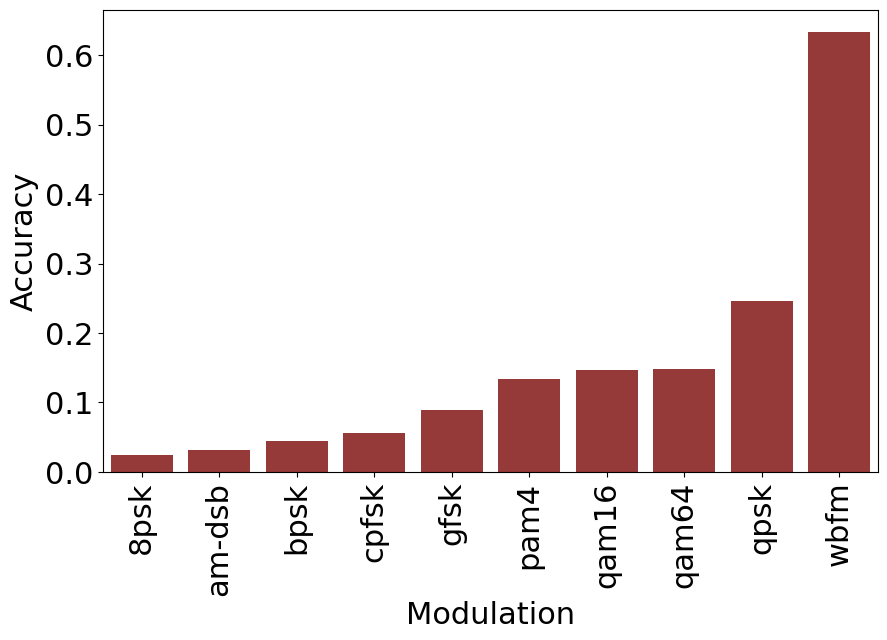

In [9]:
acc_mod = []
for mod in np.unique(true_labels[:, 0]):
    idx = true_labels[:, 0] == mod
    acc = accuracy_score(true_labels[idx, 0], pred_labels[idx])
    # print(f"Modulation: {mod}, Accuracy: {acc}")
    acc_mod.append((mod, acc))

acc_mod = np.array(acc_mod, dtype=[('mod', 'U10'), ('acc', 'f4')])

acc_mod = np.sort(acc_mod, order='acc')

# Plot the sorted bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=acc_mod['mod'], y=acc_mod['acc'], color="brown")
plt.ylabel("Accuracy", fontsize=22)
plt.xlabel("Modulation", fontsize=22)
plt.xticks(ticks=range(len(acc_mod['mod'])), labels=config.get(
    "classes").values(), fontsize=22, rotation=90)
plt.yticks(fontsize=22)

# save to experiments folder
plt.savefig(
    f"experiments/{experiment_name}/accuracy_vs_mod.png", dpi=300, bbox_inches='tight')

### **Compare results**